In [31]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from eval_utils import filter_tasks
from chunked_pooling.chunked_eval_tasks import *

OUTPUT_DIR = "results"

In [32]:
tasks = set(filter_tasks(get_eval_tasks()))
def preprocess_result():
    # Step 1: 读取 JSON 数据
    with open(f"{OUTPUT_DIR}/benchmark.json", "r") as f:
        data = json.load(f)

    # Step 2: 数据整理
    # 将所有的测试结果提取到一个列表中
    records = []
    for item in data:
        if item is None:
            continue
        assert len(item["scores"]) == 1, "More than one eval splits scores founded."
        # 大于1024的chunk size测试不全，先不看
        if item["chunk_size"] > 1024 or item["task_name"] not in tasks:
            continue
        scores = list(item["scores"].values())[0][0]
        records.append(
            {
                "dataset_revision": item.get("dataset_revision", None),
                "task_name": item.get("task_name", None),
                "mteb_version": item.get("mteb_version", None),
                "evaluation_time": item.get("evaluation_time", None),
                "kg_co2_emissions": item.get("kg_co2_emissions", None),
                "model_name": item.get("model_name", None),
                "chunking_strategy": item.get("chunking_strategy", None),
                "chunk_size": item.get("chunk_size", None),
                "n_sentences": item.get("n_sentences", None),
                "chunking_model": item.get("chunking_model", None),
                "hf_subset": scores.get("hf_subset", None),
                "main_score": scores.get("main_score", None),
                "ndcg_at_1": scores.get("ndcg_at_1", None),
                "ndcg_at_3": scores.get("ndcg_at_3", None),
                "ndcg_at_5": scores.get("ndcg_at_5", None),
                "ndcg_at_10": scores.get("ndcg_at_10", None),
                "ndcg_at_20": scores.get("ndcg_at_20", None),
                "map_at_1": scores.get("map_at_1", None),
                "map_at_3": scores.get("map_at_3", None),
                "map_at_5": scores.get("map_at_5", None),
                "map_at_10": scores.get("map_at_10", None),
                "map_at_20": scores.get("map_at_20", None),
                "recall_at_1": scores.get("recall_at_1", None),
                "recall_at_3": scores.get("recall_at_3", None),
                "recall_at_5": scores.get("recall_at_5", None),
                "recall_at_10": scores.get("recall_at_10", None),
                "recall_at_20": scores.get("recall_at_20", None),
                "precision_at_1": scores.get("precision_at_1", None),
                "precision_at_3": scores.get("precision_at_3", None),
                "precision_at_5": scores.get("precision_at_5", None),
                "precision_at_10": scores.get("precision_at_10", None),
                "precision_at_20": scores.get("precision_at_20", None),
                "mrr_at_1": scores.get("mrr_at_1", None),
                "mrr_at_3": scores.get("mrr_at_3", None),
                "mrr_at_5": scores.get("mrr_at_5", None),
                "mrr_at_10": scores.get("mrr_at_10", None),
                "mrr_at_20": scores.get("mrr_at_20", None),
                "languages": scores["languages"][0] if scores["languages"] else None,
            }
        )

    # 转换为 Pandas DataFrame
    df = pd.DataFrame(records)

    return df

In [33]:
df = preprocess_result()

In [34]:
# 定义一个自定义函数来分类 languages 列的值
def categorize_language(language):
    if language == 'eng-Latn':
        return 'Eng'
    elif language == 'zh':
        return 'Zh'
    elif language in ['en-zh', 'zh-en']:
        return 'Cross Eng-Zh'
    else:
        return '未知'

# 创建新的列 language_category
df['language_category'] = df['languages'].apply(categorize_language)

In [35]:
dataset_volume = {}
with open("sample_count.json", "r") as f:
    sample_count = json.load(f)
    for task_name, count in sample_count.items():
        if task_name not in tasks:
            continue
        dataset_volume[task_name] = count["queries"] + count["corpus"]


# 添加数据量信息
task_volume_df = pd.DataFrame(list(dataset_volume.items()), columns=['task_name', 'data_volume'])
# 将 task_volume_df 信息合并到原 DataFrame 中
df = df.merge(task_volume_df, on='task_name', how='left')

# 添加一列新的，用于表示数据量乘以得分
df['weighted_score'] = df['main_score'] * df['data_volume']


# 自定义加权平均数函数
def weighted_avg(group):
    total_weighted_score = group['weighted_score'].sum()
    total_data_volume = group['data_volume'].sum()
    weighted_avg_score = total_weighted_score / total_data_volume
    return pd.Series({'weighted_avg_score': weighted_avg_score})


# 计算总的加权平均分（不按语言分类）
avg_scores = df.groupby(['chunking_strategy', 'chunk_size', 'model_name']).apply(weighted_avg).reset_index()

# 计算按 language_category 分类的加权平均分
avg_scores_by_language = df.groupby(['chunking_strategy', 'chunk_size', 'model_name', 'language_category']).apply(weighted_avg).reset_index()

/tmp/ipykernel_1686793/186074992.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_scores = df.groupby(['chunking_strategy', 'chunk_size', 'model_name']).apply(weighted_avg).reset_index()
/tmp/ipykernel_1686793/186074992.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_scores_by_language = df.groupby(['chunking_strategy', 'chunk_size', 'model_name', 'language_category']).apply(weighted_avg).r

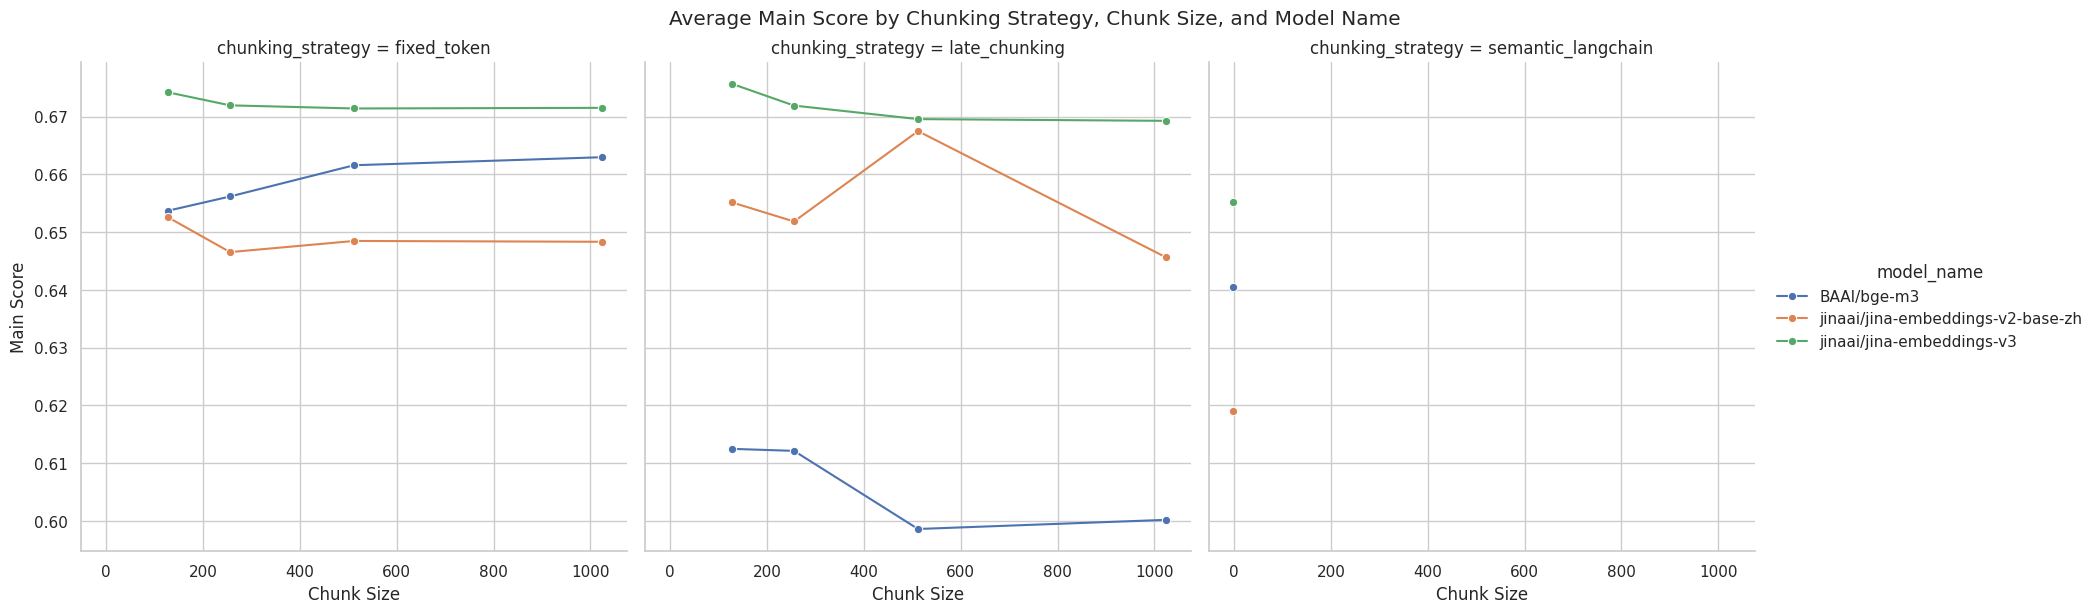

In [36]:
g = sns.FacetGrid(avg_scores, col="chunking_strategy", hue="model_name", col_wrap=3, height=6)
g.map(sns.lineplot, "chunk_size", "weighted_avg_score", marker="o")
g.add_legend()
g.set_axis_labels("Chunk Size", "Main Score")
g.fig.suptitle('Average Main Score by Chunking Strategy, Chunk Size, and Model Name', y=1.02)
plt.show()

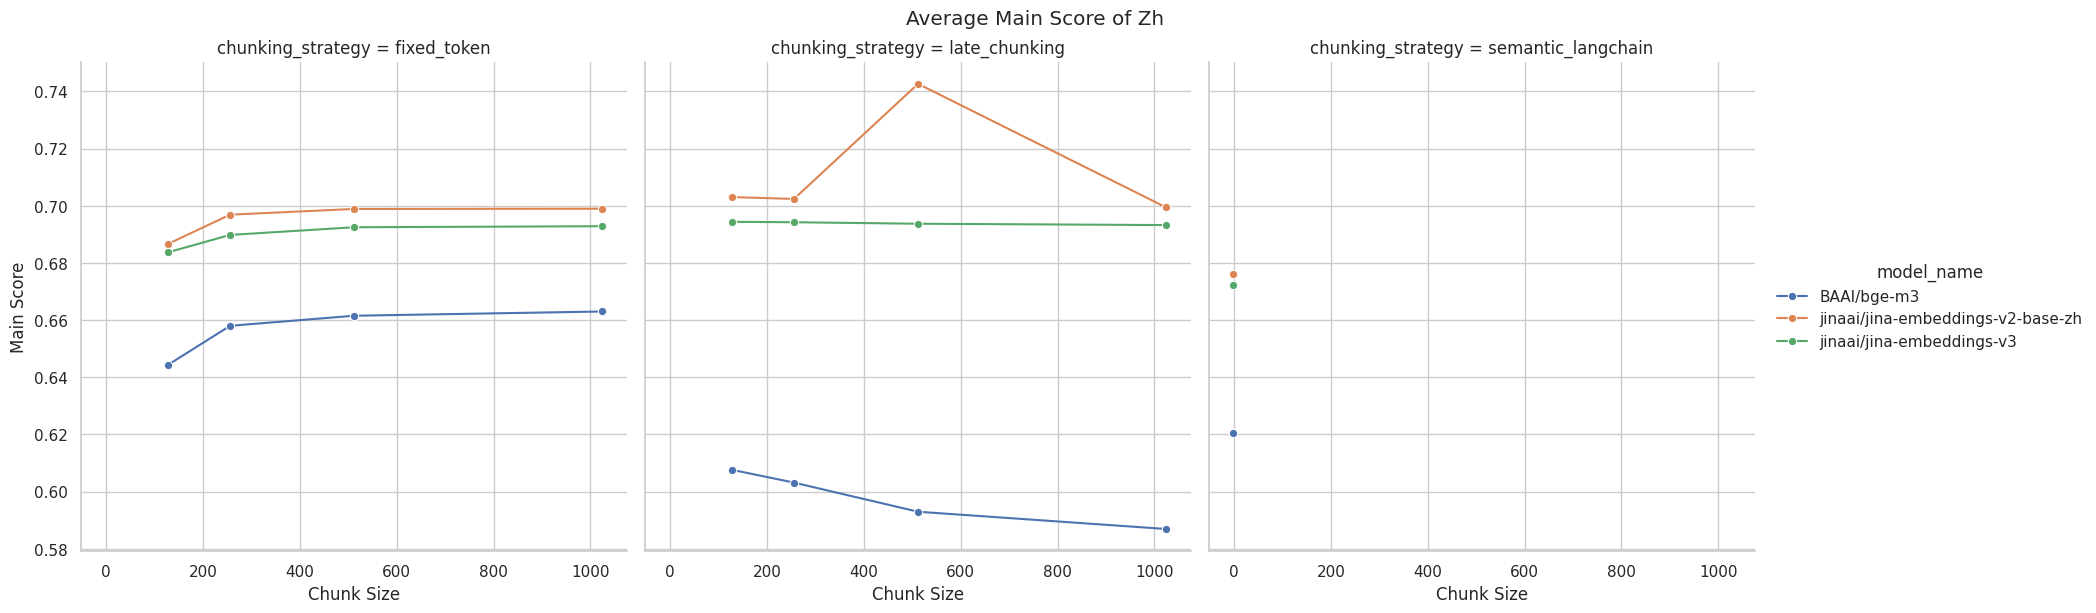

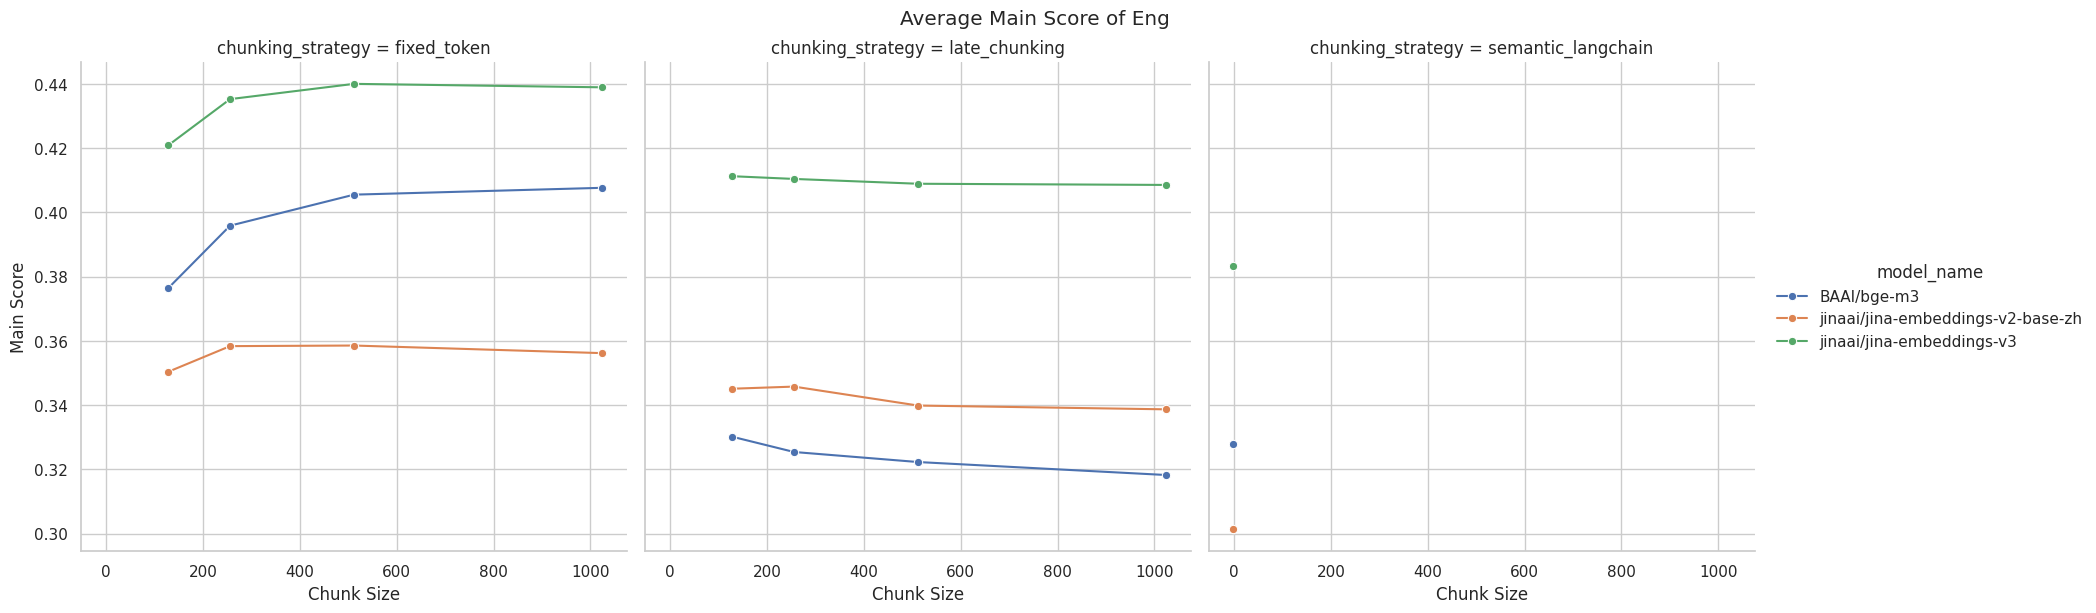

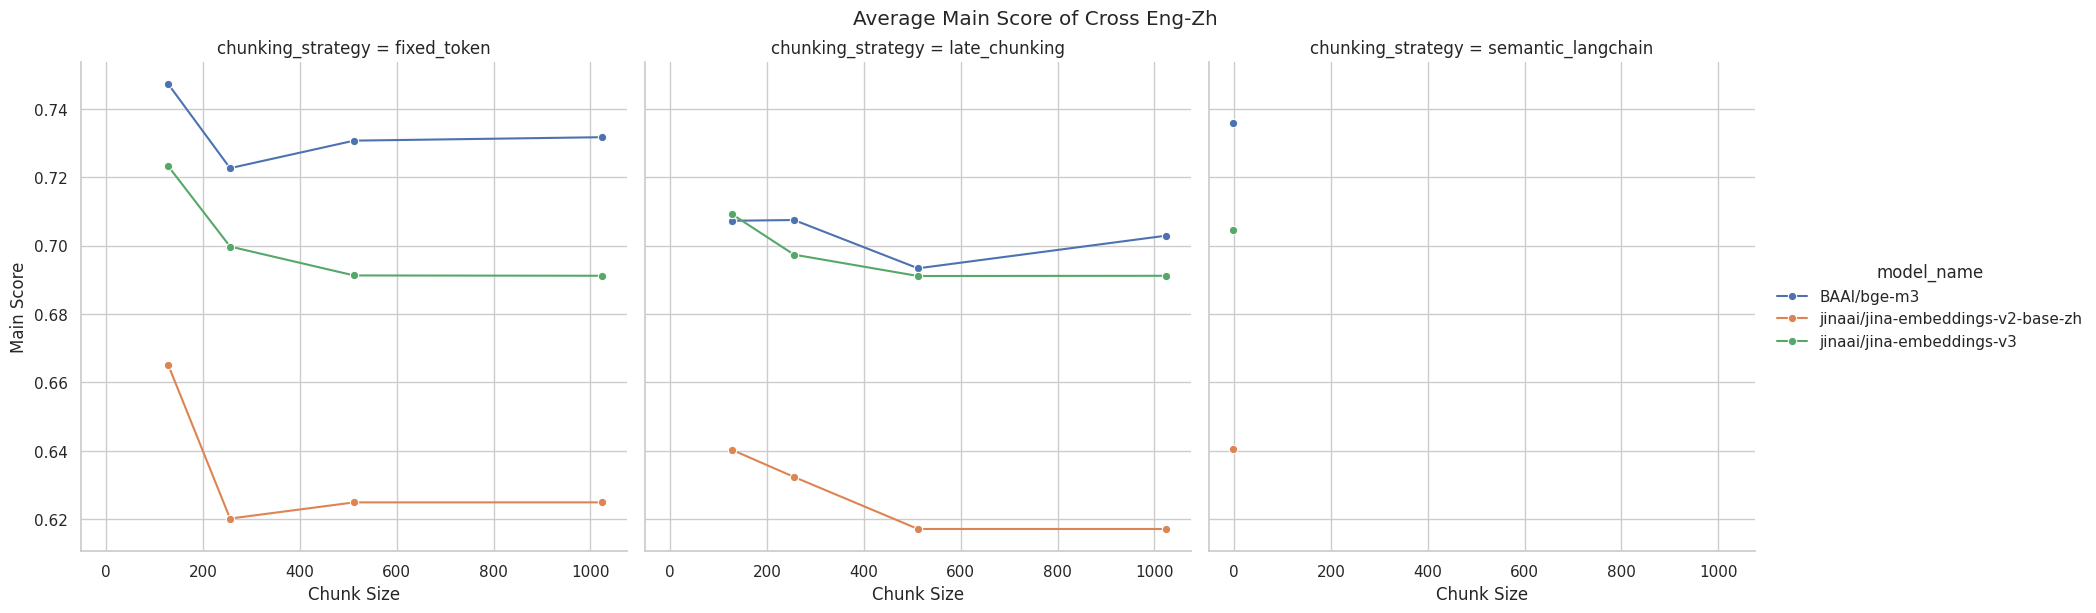

In [37]:
# 绘制按 language_category 分类的加权平均分图
categories = ['Zh', 'Eng', 'Cross Eng-Zh']
for i, category in enumerate(categories):
    cur_lang_score = avg_scores_by_language[avg_scores_by_language['language_category'] == category]
    g = sns.FacetGrid(cur_lang_score, col="chunking_strategy", hue="model_name", col_wrap=3, height=6)
    g.map(sns.lineplot, "chunk_size", "weighted_avg_score", marker="o")
    g.add_legend()
    g.set_axis_labels("Chunk Size", "Main Score")
    g.fig.suptitle(f'Average Main Score of {category}', y=1.02)